In [1]:
import torch
from torch import nn as nn
import math
from glob import glob
from torchsummary import summary
from torch_snippets import *
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms, models
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image 
import random

random.seed(1234)
#is GPU available?
gpu = torch.cuda.is_available()

#defining device where to to the computation
device = torch.device(0) if gpu else torch.device('cpu')
device

device(type='cuda', index=0)

In [2]:
# Set the folder with the samples (images) that compose a dataset and the number of classes

orig_dir   = '../Dataset/Compiled/Comparation'
nclasses   = 2

# Set the desired image size for rescaling and maximum value for normalization

width       = 224 
height      = 224
nchannels   = 3
maxval      = 255. 
input_shape = (nchannels,height,width)

# Create training, validation, and test sets.

trainset = glob("H:/Github/Deep-Learning-Unicamp/Trabalho/Dataset/Compiled/Comparation/Train"+"/*.jpg")
validset = glob("H:/Github/Deep-Learning-Unicamp/Trabalho/Dataset/Compiled/Comparation/Valid"+"/*.jpg")
testset  = glob("H:/Github/Deep-Learning-Unicamp/Trabalho/Dataset/Compiled/Comparation/Test"+"/*.jpg")
np.random.shuffle(trainset)
trainset = trainset[:len(trainset)//2]

train_aux = []
for i in range(0,len(trainset), +2):
    train_aux.append([trainset[i],trainset[i+1]])
trainset = train_aux

valid_aux = []
for i in range(0,len(validset), +2):
    valid_aux.append([validset[i],validset[i+1]])
validset = valid_aux

test_aux = []
for i in range(0,len(testset), +2):
    test_aux.append([testset[i],testset[i+1]])
testset = test_aux


# Set output model name

model_name  = 'SiameseFishNet.pth'

In [3]:
# Regular preprocessing transformation. The input is a PIL image, which after being resized,
# it is converted into a tensor for normalization using the ImageNet mean and stdev parameters.

prep = transforms.Compose([
    transforms.Resize((width, height), interpolation=transforms.InterpolationMode.BILINEAR,
                      max_size=None, antialias='True'),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Such transformations are applied everytime images are loaded from the filename lists in training, validation,
# and test sets. We will do that during training, then by adding affine transformations and increasing the number
# of epochs, we are actually implementing data augmentation.

aug = transforms.Compose([
    transforms.Resize((300, 300), interpolation=transforms.InterpolationMode.BILINEAR,
                      max_size=None, antialias='True'),
    transforms.RandomAffine(
        degrees=10, interpolation=transforms.InterpolationMode.BILINEAR, fill=0),
    transforms.CenterCrop(250),
    transforms.Resize((width, height), interpolation=transforms.InterpolationMode.BILINEAR,
                      max_size=None, antialias='True'),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Create an image dataset by applying one of the preprocessing transformations above



class ImageDataset():  # there are three mandatory functions: init, len, getitem
    def __init__(self, dataset, transform=None):
        # it gets the image true labels and set the preprocessing transformation
        self.dataset = dataset
        self.targets = [int(str(x[0]).split("\\")[-1].split("_")[0])
                        for x in self.dataset]
        self.transform = transform

    def __len__(self): return len(self.dataset)

    def __getitem__(self, ix):  # returns the item at position ix
        filename1 = self.dataset[ix][0]
        filename2 = self.dataset[ix][1]
        target = self.targets[ix]
        image1 = Image.open(filename1)  # It is a PIL image
        image2 = Image.open(filename2)  # It is a PIL image
        if (self.transform is not None):
            image1 = self.transform(image1)
            image2 = self.transform(image2)
        else:  # just reshape the image as a tensor with nchannels, height, width
            image1 = torch.from_numpy(np.array(image1)).permute(2, 0, 1).float()
            image2 = torch.from_numpy(np.array(image2)).permute(2, 0, 1).float()
        return (image1, image2, target)

    def get_path(self, ix):
        return self.dataset[ix]

In [4]:
trainset = ImageDataset(trainset, prep) # verify the difference with and wothout data augmentation
validset = ImageDataset(validset, prep)
testset  = ImageDataset(testset, prep)

In [5]:
# visualize images from the trainset

print("Number of images:", len(trainset))
image1, image2, target = trainset[30] # it executes getitem
image1     = image1.permute(1,2,0).numpy()
image2     = image2.permute(1,2,0).numpy()
image1     = 255*(image1 - np.min(image1))/(np.max(image1)-np.min(image1))
image2     = 255*(image2 - np.min(image2))/(np.max(image2)-np.min(image2))
image1     = image1.astype('uint8')
image2     = image2.astype('uint8')


Number of images: 1290

Images are 224x224x3

Class of the image:  2

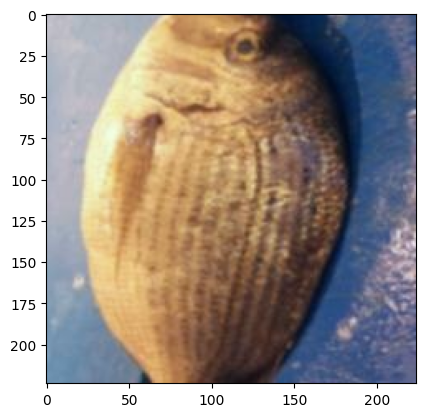

In [6]:
print("Images are {}x{}x{}".format(width,height,nchannels))
plt.imshow(image1)
print("Class of the image: ", target+1)
plt.show()

Images are 224x224x3

Class of the image:  2

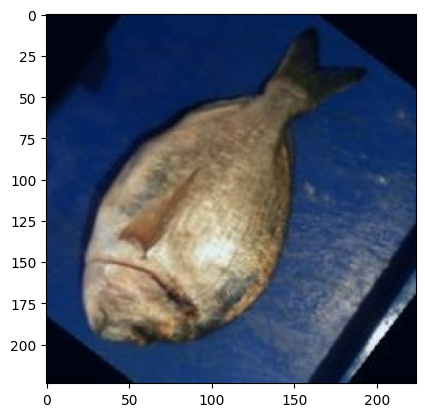

In [7]:
print("Images are {}x{}x{}".format(width,height,nchannels))
plt.imshow(image2)
print("Class of the image: ", target+1)
plt.show()

In [5]:
def conv_block(nchannels_in, nchannels_out, stride_val):
    return nn.Sequential(
        # defining convolutional layer
        nn.Conv2d(in_channels=nchannels_in, out_channels=nchannels_out, kernel_size=(3, 3),
                  stride=1, padding=1),
        # defining a batch normalization layer, which dismisses the need for bias in the previous conv layer
        nn.BatchNorm2d(num_features=nchannels_out),
        # defining activation layer
        nn.ReLU(),
        # defining a pooling layer
        nn.MaxPool2d(kernel_size=(3, 3), stride=stride_val, padding=1)
    )

class FishNet(nn.Module):

    def __init__(self, input_shape, num_classes):
        super(FishNet, self).__init__()

        # defining feature extractor
        self.features = nn.Sequential(
            conv_block(input_shape[0], 32, 2),
            conv_block(32, 64, 2),
            conv_block(64, 128, 2),
            conv_block(128, 256, 2)
        )

        # defining classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=50176, out_features=128, bias=True),
            nn.ReLU(),
            nn.Dropout(0.20),
            nn.Linear(128, 256, bias=True),
            nn.ReLU(),
            nn.Dropout(0.20),
            nn.Linear(256, 64, bias=True),
            nn.ReLU(),
            nn.Dropout(0.20),
            nn.Linear(64, num_classes)
        )

    def forward_once(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x
    
    def forward(self, x1, x2):
        x1 = self.forward_once(x1)
        x2 = self.forward_once(x2)

        return x1, x2
    


In [6]:
contrastive_thres = 1.1

class ContrastiveLoss(nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2)/2 +
            (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))/2
        acc = ((euclidean_distance > contrastive_thres) == label).float().mean()
        return loss_contrastive, acc

In [10]:
model = FishNet([3, width, height], nclasses).to(device)
optimizer = optim.Adam(model.parameters(),lr=1e-3, weight_decay=0.0001)
criterion = ContrastiveLoss()
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

In [38]:
batchsize = 100
trainload = DataLoader(trainset, batch_size=batchsize, shuffle=True)
testload  = DataLoader(testset, batch_size=batchsize, shuffle=True)
validload = DataLoader(validset, batch_size=batchsize, shuffle=True)

In [12]:
def train_batch(model, data, optimizer, criterion):
    imgsA, imgsB, labels = [t.to(device) for t in data]
    optimizer.zero_grad()
    codesA, codesB = model(imgsA, imgsB)
    loss, acc = criterion(codesA, codesB, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    imgsA, imgsB, labels = [t.to(device) for t in data]
    codesA, codesB = model(imgsA, imgsB)
    loss, acc = criterion(codesA, codesB, labels)
    return loss.item(), acc.item()

In [13]:
n_epochs = 100
log = Report(n_epochs)

for epoch in range(n_epochs):
    N = len(trainset)
    for i, data in enumerate(trainload):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(epoch+(1+i)/N, trn_loss=loss, trn_acc=acc, end='\r')
    N = len(validset)
    for i, data in enumerate(validload):
        loss, acc = validate_batch(model, data, criterion)
        log.record(epoch+(1+i)/N, val_loss=loss, val_acc=acc, end='\r')
    if (epoch+1)%20==0: log.report_avgs(epoch+1)

EPOCH: 20.000  trn_acc: 0.638  val_acc: 0.498  trn_loss: 0.433  val_loss: 0.475  (234.82s - 939.27s remaining)
EPOCH: 40.000  trn_acc: 0.650  val_acc: 0.701  trn_loss: 0.406  val_loss: 0.335  (453.56s - 680.34s remaining)
EPOCH: 60.000  trn_acc: 0.651  val_acc: 0.716  trn_loss: 0.405  val_loss: 0.333  (677.70s - 451.80s remaining)
EPOCH: 80.000  trn_acc: 0.655  val_acc: 0.662  trn_loss: 0.400  val_loss: 0.340  (902.32s - 225.58s remaining)
EPOCH: 100.000  trn_acc: 0.654  val_acc: 0.648  trn_loss: 0.404  val_loss: 0.383  (1123.03s - 0.00s remaining)


  0%|          | 0/201 [00:00<?, ?it/s]

100%|██████████| 201/201 [00:00<00:00, 5884.09it/s]


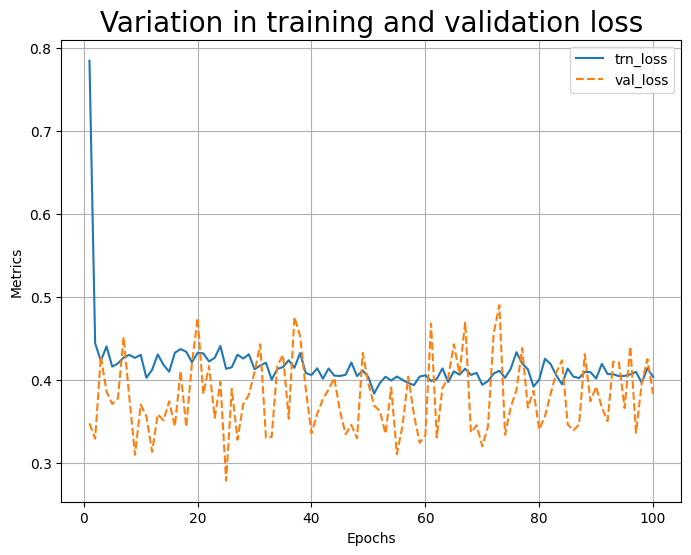

100%|██████████| 201/201 [00:00<00:00, 9323.05it/s]


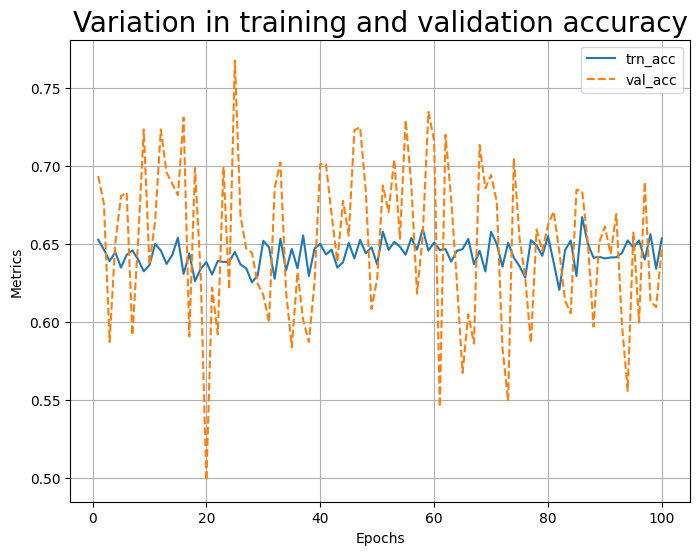

In [14]:
log.plot_epochs(['trn_loss', 'val_loss'], title='Variation in training and validation loss')
log.plot_epochs(['trn_acc', 'val_acc'], title='Variation in training and validation accuracy')

In [15]:
# Distance histograms for the cases we have the same and different persons, respectively.
different = []
same = []
model.eval()

for ix, data in enumerate(testload):
    if (ix + 1) % 100 == 0:
        print('Processing batch {}/{}'.format((ix + 1), len(testload)))
    imgsA, imgsB, labels = [t.to(device) for t in data]
    codesA, codesB = model(imgsA, imgsB)
    labels = labels.cpu()

    with torch.no_grad():
        euclidean_distance = F.pairwise_distance(codesA, codesB)
        euclidean_distance = euclidean_distance.cpu()

    for i in range(len(labels)):
        if (labels[i] == 0):  # same person
            same.append(euclidean_distance[i].item())
        else:
            different.append(euclidean_distance[i].item())

[]

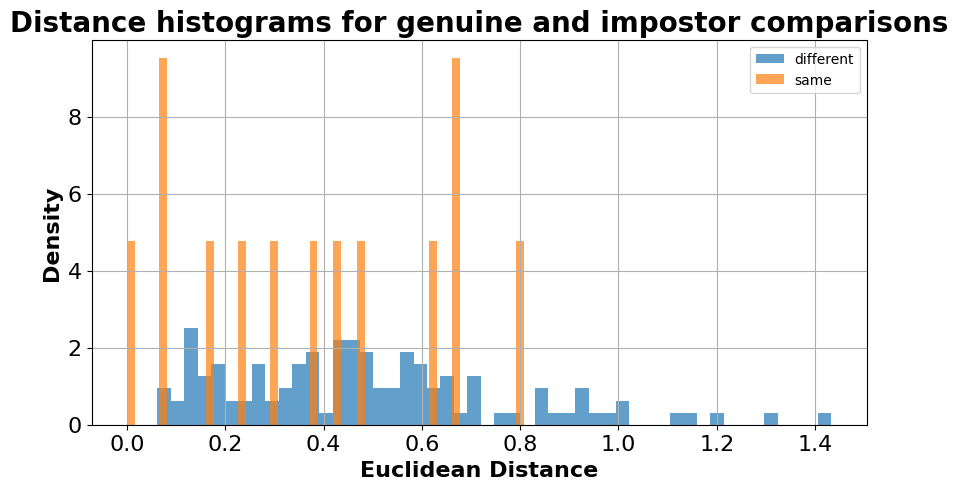

In [16]:
fig, ax = plt.subplots(figsize = (10,5))
ax.set_title('Distance histograms for genuine and impostor comparisons', fontsize = 20, fontweight = 'bold')
ax.set_xlabel('Euclidean Distance', fontsize = 16, fontweight = 'bold')
ax.set_ylabel('Density', fontsize = 16, fontweight = 'bold')
ax.hist(different,bins = 50, density=True, alpha = 0.7, label = 'different')
ax.hist(same, bins = 50, density=True, alpha = 0.7, label = 'same')
ax.tick_params(labelsize = 16, axis = 'both')
ax.legend()
ax.grid(True)
plt.plot()

In [17]:
torch.save(model.to('cpu').state_dict(), model_name)